In [20]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from sklearn.model_selection import KFold

# Load the Food-101 dataset (train only)
dataset, info = tfds.load("food101", split="train", as_supervised=True, with_info=True)

# Get the class names
class_names = info.features['label'].names[:10]  # Select the first 10 classes
num_classes = len(class_names)

# Filter the dataset to keep only the first 10 classes
def filter_classes(image, label):
    return tf.reduce_any([label == i for i in range(10)])

filtered_dataset = dataset.filter(filter_classes)

# Define augmentation layers outside the mapping function
augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

# Preprocessing function with data augmentation
def preprocess_with_augmentation(image, label):
    image = tf.image.resize(image, (224, 224))
    image = augmentation_layers(image)
    image = image / 255.0  # Normalization [0,1]
    return image, label

# Apply preprocessing
filtered_dataset = filtered_dataset.map(preprocess_with_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

# Calculate dataset size and split indices
dataset_size = sum(1 for _ in filtered_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

# Split the dataset into training and validation sets
train_ds = filtered_dataset.take(train_size)
val_ds = filtered_dataset.skip(train_size)

# Batch and prefetch the datasets
train_ds = train_ds.batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)


In [21]:
# Cnn model
# Load the pre-trained ResNet50 model
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base layers

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [22]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
# Display the model structure
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_13          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,696,138 (98.02 MB)

 Trainable params: 2,108,426 (8.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [24]:
# Train the model
history = model.fit(train_ds, epochs=70, validation_data=val_ds, callbacks=[
    tf.keras.callbacks.ModelCheckpoint(filepath='resnet_model.weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
])

Epoch 1/70
     94/Unknown 45s 337ms/step - accuracy: 0.1164 - loss: 2.4491
Epoch 1: val_loss improved from inf to 2.24538, saving model to resnet_model.weights.h5
94/94 ━━━━━━━━━━━━━━━━━━━━ 84s 762ms/step - accuracy: 0.1165 - loss: 2.4481 - val_accuracy: 0.1567 - val_loss: 2.2454 - learning_rate: 0.0010
Epoch 2/70
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.1548 - loss: 2.2475
Epoch 2: val_loss improved from 2.24538 to 2.24234, saving model to resnet_model.weights.h5
94/94 ━━━━━━━━━━━━━━━━━━━━ 52s 553ms/step - accuracy: 0.1547 - loss: 2.2476 - val_accuracy: 0.1427 - val_loss: 2.2423 - learning_rate: 0.0010
Epoch 3/70
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.1478 - loss: 2.2443
Epoch 3: val_loss improved from 2.24234 to 2.23295, saving model to resnet_model.weights.h5
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 573ms/step - accuracy: 0.1478 - loss: 2.2443 - val_accuracy: 0.1427 - val_loss: 2.2329 - learning_rate: 0.0010
Epoch 4/70
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - 

In [25]:
from google.colab import files
# Download the saved model
files.download('resnet_model.weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
# Evaluation
test_loss, test_acc = model.evaluate(val_ds)
print(f'\nValidation Accuracy: {test_acc * 100:.2f}%')
print(f'\nValidation Loss: {test_loss:.4f}')

24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 228ms/step - accuracy: 0.1844 - loss: 2.1769

Validation Accuracy: 18.53%

Validation Loss: 2.1944


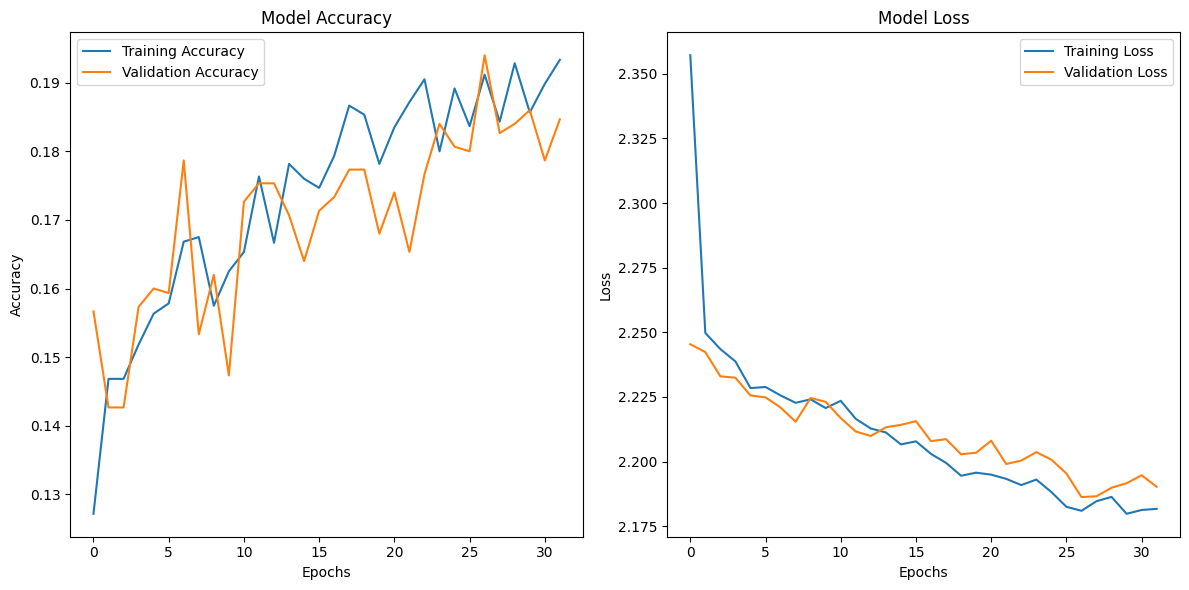

In [27]:
import matplotlib.pyplot as plt
# Plot accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Classification report
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in val_ds], axis=0)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 414ms/step
Classification Report:
                   precision    recall  f1-score   support

        apple_pie     0.0619    0.0461    0.0528       152
   baby_back_ribs     0.1956    0.4593    0.2743       135
          baklava     0.1614    0.5870    0.2531       138
   beef_carpaccio     0.2410    0.1290    0.1681       155
     beef_tartare     0.2581    0.0510    0.0851       157
       beet_salad     0.3166    0.4375    0.3673       144
         beignets     0.2500    0.0353    0.0619       170
         bibimbap     0.1771    0.1024    0.1298       166
    bread_pudding     0.1404    0.0556    0.0796       144
breakfast_burrito     0.0897    0.0504    0.0645       139

         accuracy                         0.1860      1500
        macro avg     0.1892    0.1953    0.1537      1500
     weighted avg     0.1907    0.1860    0.1499      1500



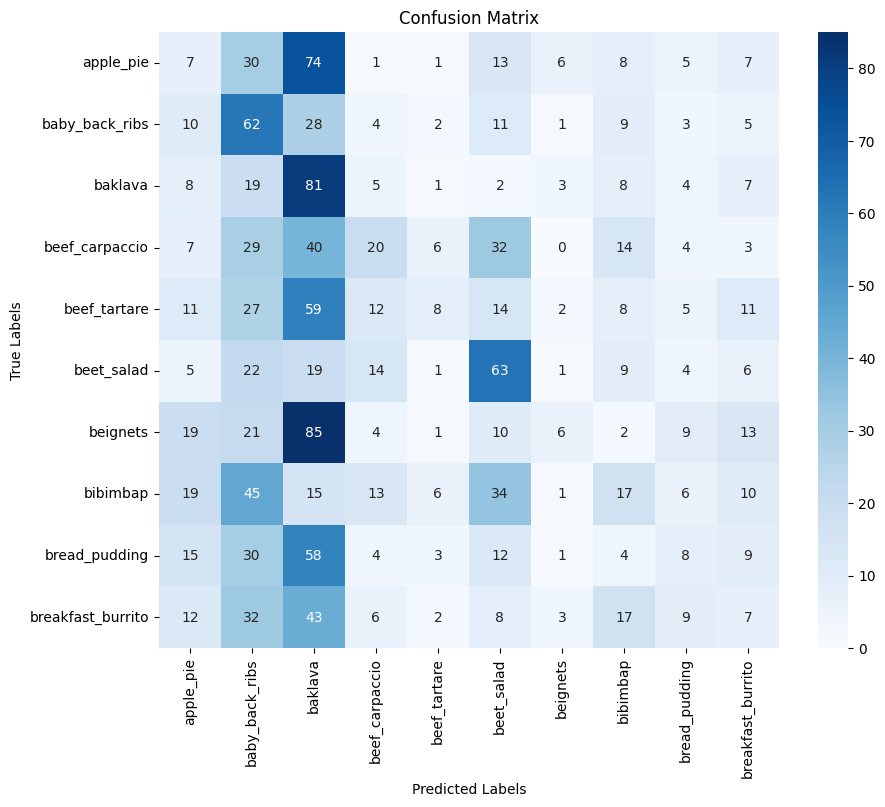

In [29]:
#confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()